## Simulated Betting Environment using the Logistic Regression Model for Predictive Analytics

1. Load the libraries needed for the development of the betting environment.

In [15]:
import joblib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

2. Load the Logistic Regression model using joblib library.

In [16]:
# Load the LogRg Model

model = joblib.load('logistic_regression_model.pkl')

3. Load the test data 

In [17]:
# Load the test data

X_test = joblib.load('X_test.pkl')
y_test = joblib.load('y_test.pkl')

# Ensure that X_test and y_test have the same length
assert len(X_test) == len(y_test), "X_test and y_test must have the same number of rows"

4. Define a function to simulate the betting environment using different strategies: 
* 1. Low-Risk Strategy
* 2. High-Risk Strategy 
* 3. Martingale Strategy 
* 4. Flat Betting Strategy 

In [18]:
# Simulated betting environment for low and high-risk strategies
def simulate_betting_low_risk(X_test, y_test, model, initial_balance=1000):
    balance = initial_balance
    bet_history = []
    
    for i in range(len(X_test)):
        row = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)
        prediction_prob = model.predict_proba(row)[0]
        predicted_class = model.predict(row)[0]

        if prediction_prob[1] > 0.7:
            bet_amount = balance * 0.05  # Bet 5% of current balance
            odds = 1 / prediction_prob[1]
        else:
            continue  # Skip this game

        actual_result = y_test.iloc[i]
        if predicted_class == actual_result:
            payout = bet_amount * odds
            balance += payout - bet_amount
        else:
            balance -= bet_amount

        bet_history.append({
            'Game': i,
            'Predicted_Class': predicted_class,
            'Actual_Result': actual_result,
            'Bet_Amount': bet_amount,
            'Balance': balance,
            'Odds': odds,
            'Payout': payout if predicted_class == actual_result else 0
        })

    return pd.DataFrame(bet_history), balance

def simulate_betting_high_risk(X_test, y_test, model, initial_balance=1000):
    balance = initial_balance
    bet_history = []
    
    for i in range(len(X_test)):
        row = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)
        prediction_prob = model.predict_proba(row)[0]
        predicted_class = model.predict(row)[0]

        # Define high-risk as predictions with probabilities between 0.3 and 0.5
        if 0.3 <= prediction_prob[1] < 0.5:
            bet_amount = balance * 0.02  # Bet 2% of current balance
            odds = 1 / (1 - prediction_prob[1])
        else:
            continue  # Skip this game

        actual_result = y_test.iloc[i]
        if predicted_class == actual_result:
            payout = bet_amount * odds
            balance += payout - bet_amount
        else:
            balance -= bet_amount

        bet_history.append({
            'Game': i,
            'Predicted_Class': predicted_class,
            'Actual_Result': actual_result,
            'Bet_Amount': bet_amount,
            'Balance': balance,
            'Odds': odds,
            'Payout': payout if predicted_class == actual_result else 0
        })

    return pd.DataFrame(bet_history), balance



def simulate_betting_martingale(X_test, y_test, model, initial_balance=1000, initial_bet=10):
    balance = initial_balance
    bet_amount = initial_bet
    bet_history = []
    
    for i in range(len(X_test)):
        row = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)
        prediction_prob = model.predict_proba(row)[0]
        predicted_class = model.predict(row)[0]

        if balance <= 0:
            break  # Stop if balance is zero or negative
        
        odds = 1 / prediction_prob[1] if prediction_prob[1] > 0.5 else 1 / (1 - prediction_prob[1])

        actual_result = y_test.iloc[i]
        if predicted_class == actual_result:
            payout = bet_amount * odds
            balance += payout - bet_amount
            bet_amount = initial_bet  # Reset bet amount
        else:
            balance -= bet_amount
            bet_amount *= 2  # Double the bet amount

        bet_history.append({
            'Game': i,
            'Predicted_Class': predicted_class,
            'Actual_Result': actual_result,
            'Bet_Amount': bet_amount,
            'Balance': balance,
            'Odds': odds,
            'Payout': payout if predicted_class == actual_result else 0
        })

    return pd.DataFrame(bet_history), balance

def simulate_betting_flat(X_test, y_test, model, initial_balance=1000, bet_fraction=0.05):
    balance = initial_balance
    bet_history = []
    
    for i in range(len(X_test)):
        row = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)
        prediction_prob = model.predict_proba(row)[0]
        predicted_class = model.predict(row)[0]

        bet_amount = balance * bet_fraction
        odds = 1 / prediction_prob[1] if prediction_prob[1] > 0.5 else 1 / (1 - prediction_prob[1])

        actual_result = y_test.iloc[i]
        if predicted_class == actual_result:
            payout = bet_amount * odds
            balance += payout - bet_amount
        else:
            balance -= bet_amount

        bet_history.append({
            'Game': i,
            'Predicted_Class': predicted_class,
            'Actual_Result': actual_result,
            'Bet_Amount': bet_amount,
            'Balance': balance,
            'Odds': odds,
            'Payout': payout if predicted_class == actual_result else 0
        })

    return pd.DataFrame(bet_history), balance

5. Run the simulation

In [19]:
low_risk_df, low_balance = simulate_betting_low_risk(X_test, y_test, model)
high_risk_df, high_balance = simulate_betting_high_risk(X_test, y_test, model)
martingale_df, martingale_balance = simulate_betting_martingale(X_test, y_test, model)
flat_df, flat_balance = simulate_betting_flat(X_test, y_test, model)

6. Analyze the profitability

In [20]:
# Analyze profitability
def analyze_strategy(df, initial_balance):
    total_bets = len(df)
    final_balance = df.iloc[-1]['Balance'] if not df.empty else initial_balance
    total_profit = final_balance - initial_balance
    win_rate = df[df['Payout'] > 0].shape[0] / total_bets if total_bets > 0 else 0
    
    return {
        'Total Bets': total_bets,
        'Final Balance': final_balance,
        'Total Profit': total_profit,
        'Win Rate': win_rate
    }

# Analyze profitability
low_risk_analysis = analyze_strategy(low_risk_df, initial_balance=1000)
high_risk_analysis = analyze_strategy(high_risk_df, initial_balance=1000)
martingale_analysis = analyze_strategy(martingale_df, initial_balance=1000)
flat_analysis = analyze_strategy(flat_df, initial_balance=1000)

# Display results
print("Low-Risk Strategy Analysis:", low_risk_analysis)
print("High-Risk Strategy Analysis:", high_risk_analysis)
print("Martingale Strategy Analysis:", martingale_analysis)
print("Flat Betting Strategy Analysis:", flat_analysis)


Low-Risk Strategy Analysis: {'Total Bets': 1787, 'Final Balance': np.float64(5270.063178138435), 'Total Profit': np.float64(4270.063178138435), 'Win Rate': 0.9541130386121992}
High-Risk Strategy Analysis: {'Total Bets': 257, 'Final Balance': np.float64(1845.5396599908468), 'Total Profit': np.float64(845.5396599908468), 'Win Rate': 0.6809338521400778}
Martingale Strategy Analysis: {'Total Bets': 3423, 'Final Balance': np.float64(2182.658662248825), 'Total Profit': np.float64(1182.6586622488248), 'Win Rate': 0.90651475314052}
Flat Betting Strategy Analysis: {'Total Bets': 3423, 'Final Balance': np.float64(77505.83783448282), 'Total Profit': np.float64(76505.83783448282), 'Win Rate': 0.90651475314052}


7. Visualize the results 

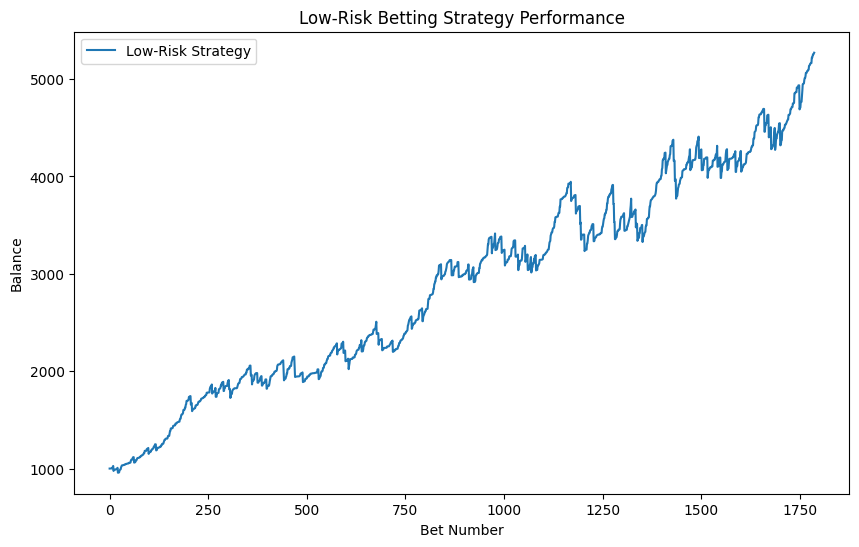

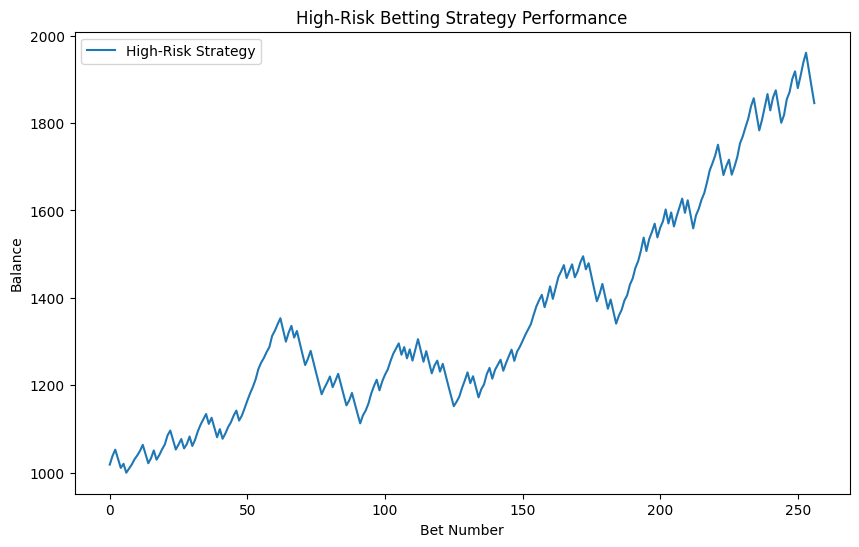

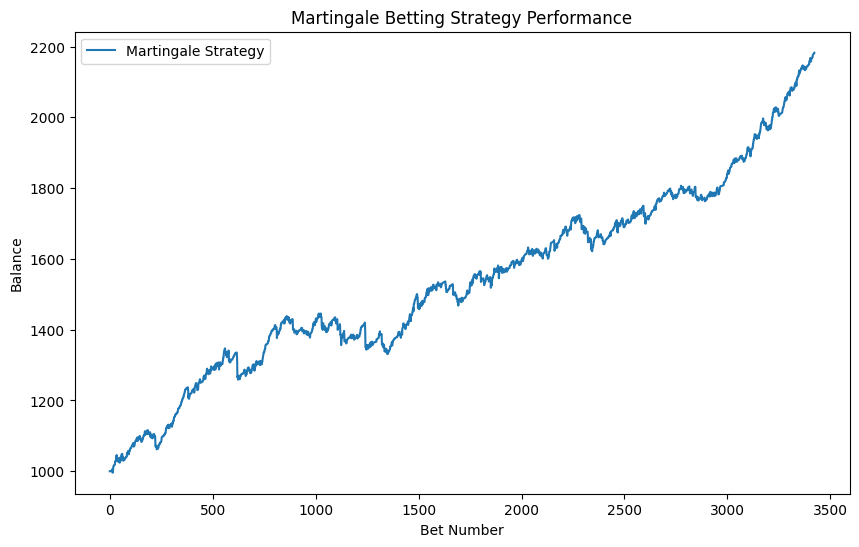

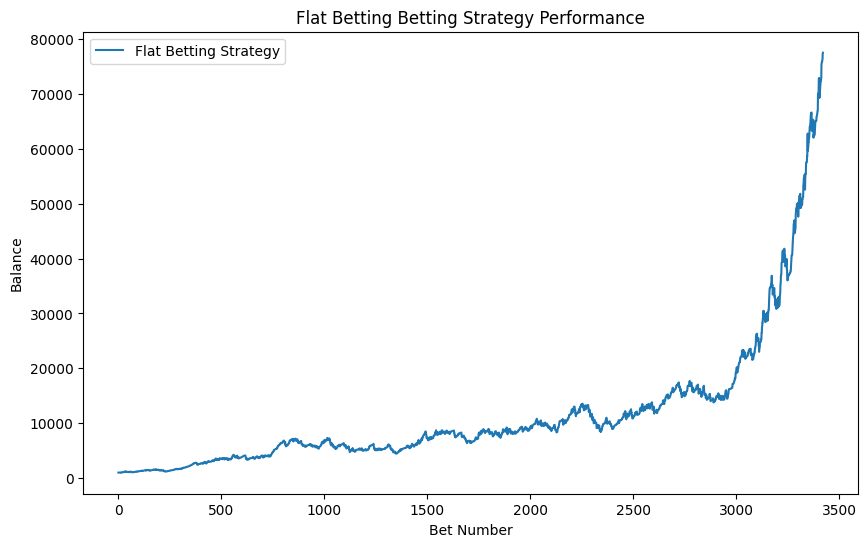

In [21]:
# Visualization
def plot_betting_strategy(df, strategy_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Balance'], label=f'{strategy_name} Strategy')
    plt.xlabel('Bet Number')
    plt.ylabel('Balance')
    plt.title(f'{strategy_name} Betting Strategy Performance')
    plt.legend()
    plt.show()
    
# Plot results
plot_betting_strategy(low_risk_df, 'Low-Risk')
plot_betting_strategy(high_risk_df, 'High-Risk')
plot_betting_strategy(martingale_df, 'Martingale')
plot_betting_strategy(flat_df, 'Flat Betting')
